In [18]:
# pip install tensorflow
# pip install tensorflow-macos
# pip install tensorflow-metal
# pip install scikit-learn
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import re
import numpy as np
import os
tf.config.list_physical_devices("GPU")
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [19]:
channels=3
image_size=256
batch_size=32
epochs=12

In [20]:
dataset=tf.keras.utils.image_dataset_from_directory(
    directory="TomatoVillage",
    shuffle=True,
    batch_size=batch_size,
    image_size=(image_size,image_size)
)

Found 16011 files belonging to 10 classes.


In [21]:
#get the names of the classes
class_names= dataset.class_names
print(class_names,len(class_names))
num_classes=len(class_names)

['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy'] 10


we have 10 classes that our model need to classify into.

In [22]:
#we look at dataset's structure
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[9 8 1 7 9 0 9 3 7 9 7 6 4 9 7 9 4 4 8 7 7 8 7 7 6 3 9 9 3 0 0 4]


2025-08-07 14:17:58.071612: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


I split the dataset into 80-10-10, training,test,val data respectively. This is done by writing a function for it.

In [23]:
def dataset_partition_split(dataset,training_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=dataset.cardinality()):
    length=len(dataset)

    if shuffle:
        dataset=dataset.shuffle(buffer_size=shuffle_size,seed=1)

    train_size=int(training_split*length)
    val_size=int(val_split*length)
    training_ds=dataset.take(train_size)
    val_ds= dataset.skip(train_size).take(val_size)
    test_ds=dataset.skip(train_size).skip(val_size)


    return training_ds,val_ds,test_ds

In [24]:
train_ds,val_ds,test_ds=dataset_partition_split(dataset)

In [25]:
print(len(train_ds),
len(val_ds),
len(test_ds))

400 50 51


In [26]:
for image,label in train_ds.take(1):
    # unique,counts=np.unique(label.numpy())
    print(label.numpy())
    print(np.unique(label.numpy()))
    # print(unique)
    # print(counts)

[7 7 7 1 4 7 0 0 5 0 3 4 4 7 6 7 2 3 2 7 5 1 5 7 5 9 3 2 3 7 0 6]
[0 1 2 3 4 5 6 7 9]


2025-08-07 14:18:07.466963: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [27]:
resize_rescale=models.Sequential(
    [
        layers.Resizing(image_size,image_size),
        layers.Rescaling(1./255) # standardise the data
    ]
)

In [28]:
augment=models.Sequential(
    [
        layers.RandomFlip(),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.1),
        layers.RandomZoom(0.1)
    ]
)

In [29]:
#data augmentation and resizing for train_ds
input_shape=(None,image_size,image_size,channels)
train_ds = train_ds.map(lambda x, y: (resize_rescale(x), y))  # rescale before augment
train_ds = train_ds.map(lambda x, y: (augment(x, training=True),y))
val_ds=val_ds.map(lambda x, y: (resize_rescale(x), y))
test_ds=test_ds.map(lambda x, y: (resize_rescale(x), y))

In [30]:
#loading the data
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [31]:
model=models.Sequential(
    [
    layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    # The second convolution
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.BatchNormalization(),    
    layers.MaxPooling2D(2,2),
    # The third convolution
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a dense layer
    layers.Flatten(),
    # 128 neuron in the fully-connected layer
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    # 5 output neurons for 5 classes with the softmax activation
    layers.Dense(num_classes,activation='softmax')  #softmax: normalise prob of classes
    ]
)
# model.build(input_shape=input_shape)

In [32]:
model.compile(optimizer="adam",
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),# the labels are represented as integers corresponding to the class indices. The true labels are integers where each integer represents the class index.
            metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [34]:

checkpoint_path='checkpoints/ckpt/checkpoint.model.keras'
checkpoint_dir=os.path.dirname(checkpoint_path)

#create checkpoint callback
cp_callback= tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_best_only=True,
    monitor="val_loss",
    mode='min',
    verbose=1)
#create early stopping
es_callback=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=0,
    mode='min',
    restore_best_weights=True
)
#create Learning rate scheduler?
# LRS_callback=tf.keras.callbacks.LearningRateScheduler(

# )

history=model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=batch_size,
    callbacks=[cp_callback,es_callback],
    epochs=epochs
)

Epoch 1/12


2025-08-07 14:18:08.592421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-08-07 14:18:19.151532: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:52: Filling up shuffle buffer (this may take a while): 24 of 1000
2025-08-07 14:18:29.253674: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:52: Filling up shuffle buffer (this may take a while): 81 of 1000
2025-08-07 14:18:49.279492: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:52: Filling up shuffle buffer (this may take a while): 190 of 1000
2025-08-07 14:18:59.284062: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:52: Filling up shuffle buffer (this may take a while): 243 of 1000
2025-08-07 14:19:19.281745: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:52: Filling up shuffle buffer (this may take a while): 351 of 10

400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.3926 - loss: 71.8370

2025-08-07 14:23:02.638041: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:39: Filling up shuffle buffer (this may take a while): 285 of 501
2025-08-07 14:23:08.251572: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-08-07 14:23:09.837025: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.



Epoch 1: val_loss improved from inf to 143.19611, saving model to checkpoints/ckpt/checkpoint.model.keras
400/400 ━━━━━━━━━━━━━━━━━━━━ 307s 563ms/step - accuracy: 0.3928 - loss: 71.8542 - val_accuracy: 0.3319 - val_loss: 143.1961
Epoch 2/12
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.6012 - loss: 70.5683
Epoch 2: val_loss did not improve from 143.19611
400/400 ━━━━━━━━━━━━━━━━━━━━ 251s 612ms/step - accuracy: 0.6012 - loss: 70.5560 - val_accuracy: 0.3581 - val_loss: 329.8050
Epoch 3/12
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.6827 - loss: 46.3186
Epoch 3: val_loss improved from 143.19611 to 136.93507, saving model to checkpoints/ckpt/checkpoint.model.keras
400/400 ━━━━━━━━━━━━━━━━━━━━ 240s 598ms/step - accuracy: 0.6827 - loss: 46.3101 - val_accuracy: 0.5562 - val_loss: 136.9351
Epoch 4/12
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - accuracy: 0.7006 - loss: 31.4434
Epoch 4: val_loss improved from 136.93507 to 112.17847, saving model to checkpoints/ckpt/chec

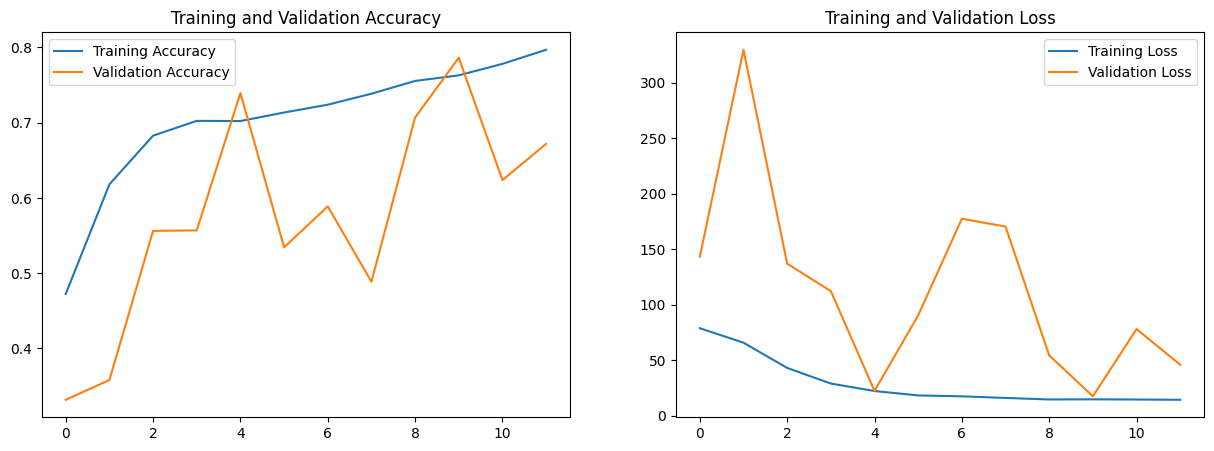

In [35]:
#plot the accuracy and loss
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(history.epoch,history.history['accuracy'],label="Training Accuracy")
plt.plot(history.epoch,history.history['val_accuracy'],label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.epoch,history.history['loss'],label="Training Loss")
plt.plot(history.epoch,history.history['val_loss'],label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()


MODEL FAILURE! suspect lr too high!

In [36]:
model.evaluate(test_ds)

2025-08-07 15:02:03.523933: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:58: Filling up shuffle buffer (this may take a while): 1 of 1000
2025-08-07 15:02:04.649122: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


51/51 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - accuracy: 0.7826 - loss: 15.1893


[13.109947204589844, 0.7953431606292725]

first image to predict
actual label: Tomato_Bacterial_spot
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
predicted label: Tomato_Bacterial_spot
confidence 100.0


2025-08-07 15:02:09.295593: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


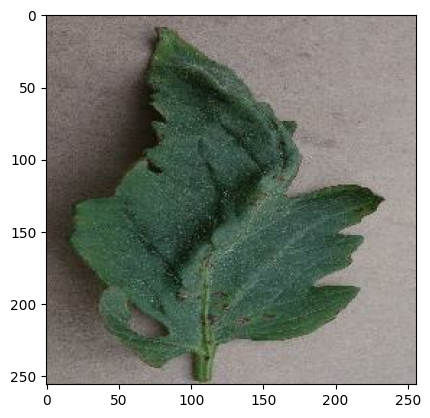

In [37]:
#first image
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = (images_batch[0].numpy()*255).astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    print("confidence",round(100*(np.max(batch_prediction[0])),2))

In [38]:
#predicting function

def predicting(model,img):
    img_array=tf.keras.utils.img_to_array(img)
    img_array=tf.expand_dims(img_array,0)

    prediction= model.predict(img_array)

    predicted_class=class_names[np.argmax(prediction[0])]
    confidence= round(100*(np.max(prediction[0])),2)
    return predicted_class,confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━

2025-08-07 15:02:12.398516: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


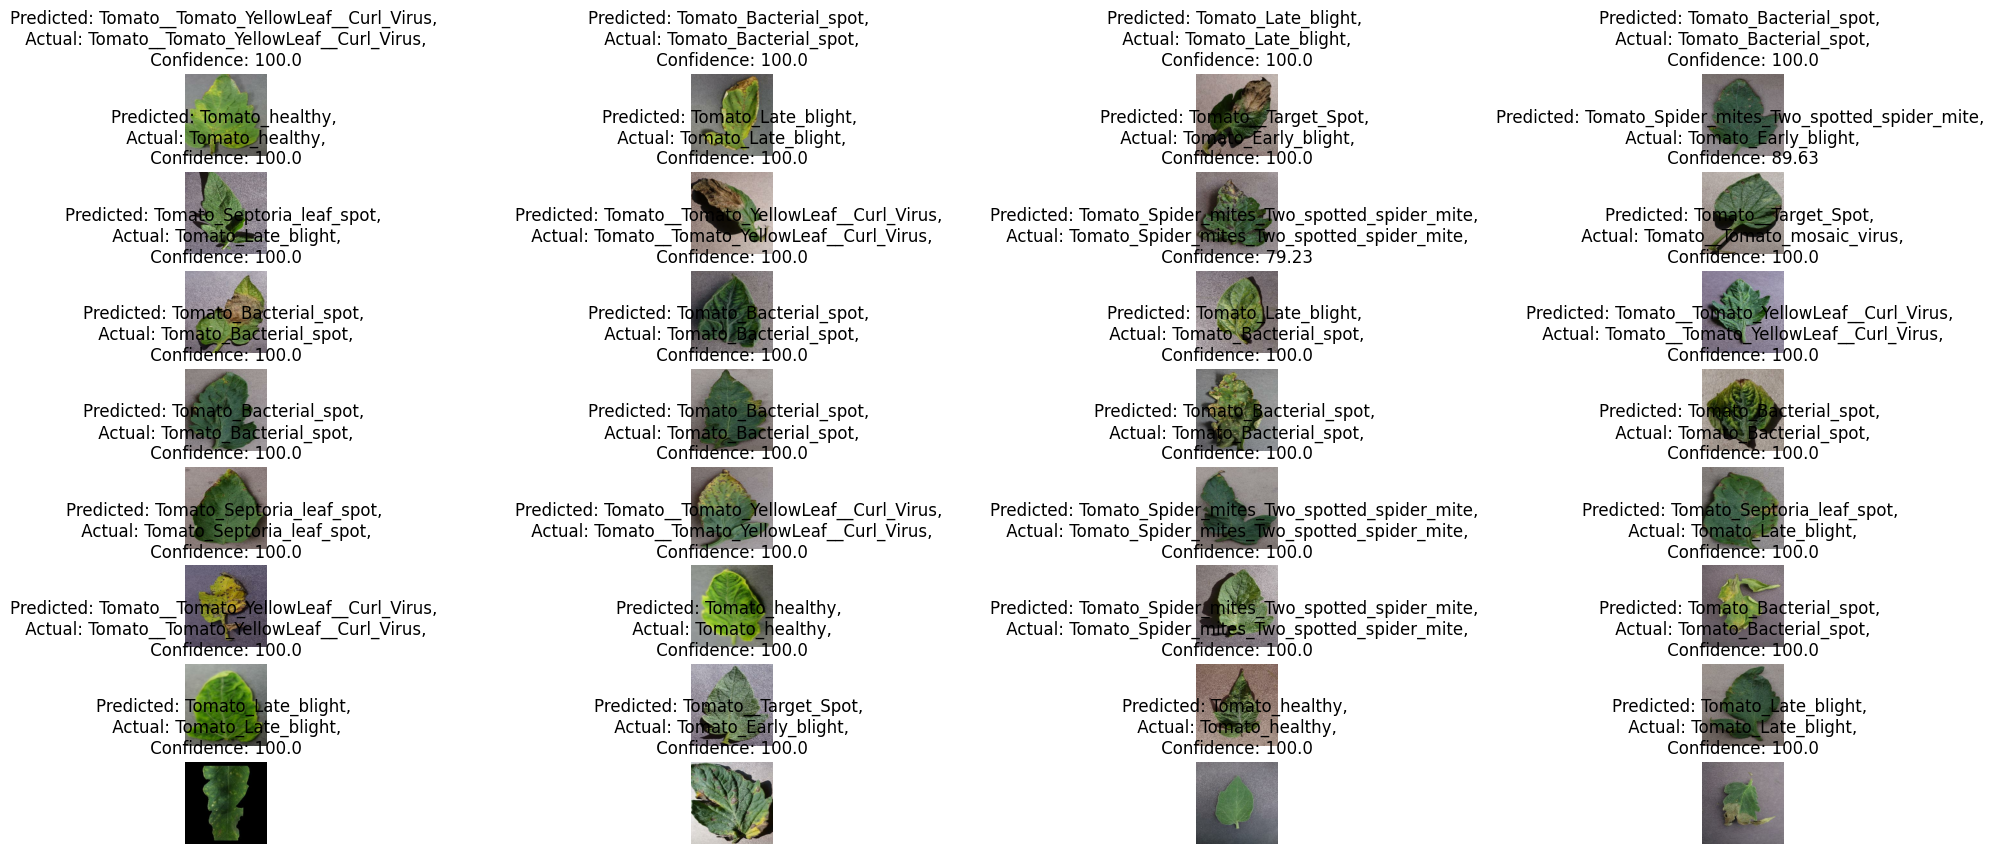

In [39]:
plt.figure(figsize=(25,10))
for images, labels in test_ds.take(1):
    for i in range(len(images)):
        plt.subplot(8,4,i+1)
        plt.imshow((images[i].numpy()*255).astype('uint8'))

        predicted_class,confidence=predicting(model,images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Predicted: {predicted_class}, \n Actual: {actual_class}, \n Confidence: {confidence} ")
        plt.axis("off")

In [40]:
#we save the model in format "num_accuracy"
model_numbers=[]
for m in os.listdir("models"):
    if not m.startswith("."):
        list_number=re.findall('^[0-9]+',m)
        model_numbers.append(int(list_number[0]))   
print(model_numbers)
model_version= max(model_numbers + [0])+1
model_version
loss,accuracy = model.evaluate(test_ds)
accuracy=round(accuracy,2)
model.save(f"models/{model_version}_{accuracy}.keras")

[5, 6, 3, 7, 4, 8, 1, 2]
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.7925 - loss: 13.5118


In [64]:
model=models.load_model("models/9_0.8.keras")
model.evaluate(test_ds)

51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.8090 - loss: 11.7418


[13.10994815826416, 0.7953431606292725]

In [41]:
#we redo model here, try edit learning rate and add a layer

model_edited=models.Sequential(
    [
        #first convolution
    layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    #second convolution
    layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    #third convolution
    layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    #fourth convolution
    layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes,activation='softmax')  #softmax: normalise prob of classes
    ]
)
model_edited.build(input_shape=input_shape)

#create Learning rate scheduler
LRS=tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True
)

optimizer=tf.keras.optimizers.Adam(learning_rate=LRS)
model_edited.compile(optimizer=optimizer,
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),# the labels are represented as integers corresponding to the class indices. The true labels are integers where each integer represents the class index.
            metrics=['accuracy'])

In [42]:
checkpoint_path='checkpoints/ckpt/checkpoint.model.keras'
checkpoint_dir=os.path.dirname(checkpoint_path)

#create checkpoint callback
cp_callback= tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_best_only=True,
    monitor="val_loss",
    mode='min',
    verbose=1)
#create early stopping
es_callback=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=0,
    mode='min',
    restore_best_weights=True
)


history_edited=model_edited.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=batch_size,
    callbacks=[cp_callback,es_callback],
    epochs=epochs
)

Epoch 1/12
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - accuracy: 0.4173 - loss: 26.1536
Epoch 1: val_loss improved from inf to 148.56148, saving model to checkpoints/ckpt/checkpoint.model.keras
400/400 ━━━━━━━━━━━━━━━━━━━━ 283s 689ms/step - accuracy: 0.4175 - loss: 26.1602 - val_accuracy: 0.1713 - val_loss: 148.5615
Epoch 2/12
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 663ms/step - accuracy: 0.6134 - loss: 29.3612
Epoch 2: val_loss improved from 148.56148 to 76.22475, saving model to checkpoints/ckpt/checkpoint.model.keras
400/400 ━━━━━━━━━━━━━━━━━━━━ 273s 683ms/step - accuracy: 0.6135 - loss: 29.3507 - val_accuracy: 0.3487 - val_loss: 76.2248
Epoch 3/12
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 670ms/step - accuracy: 0.6965 - loss: 17.1961
Epoch 3: val_loss improved from 76.22475 to 22.06186, saving model to checkpoints/ckpt/checkpoint.model.keras
400/400 ━━━━━━━━━━━━━━━━━━━━ 276s 689ms/step - accuracy: 0.6965 - loss: 17.1915 - val_accuracy: 0.6456 - val_loss: 22.0619
Epoch 4/12
400/400 ━━━━━━━━━━━━━━━━━

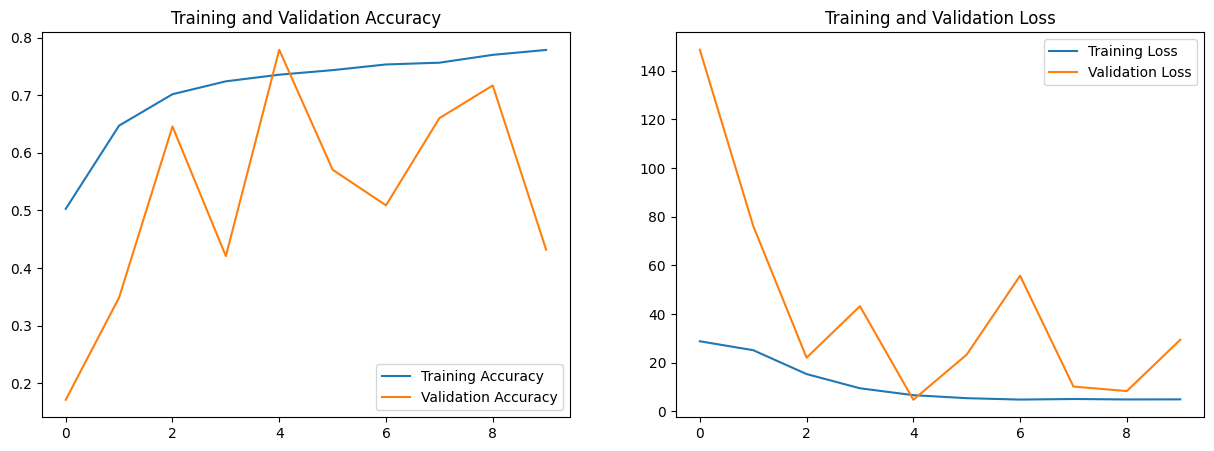

In [43]:
#plot the accuracy and loss
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(history_edited.epoch,history_edited.history['accuracy'],label="Training Accuracy")
plt.plot(history_edited.epoch,history_edited.history['val_accuracy'],label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.subplot(1,2,2)
plt.plot(history_edited.epoch,history_edited.history['loss'],label="Training Loss")
plt.plot(history_edited.epoch,history_edited.history['val_loss'],label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━

2025-08-07 15:52:09.565776: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


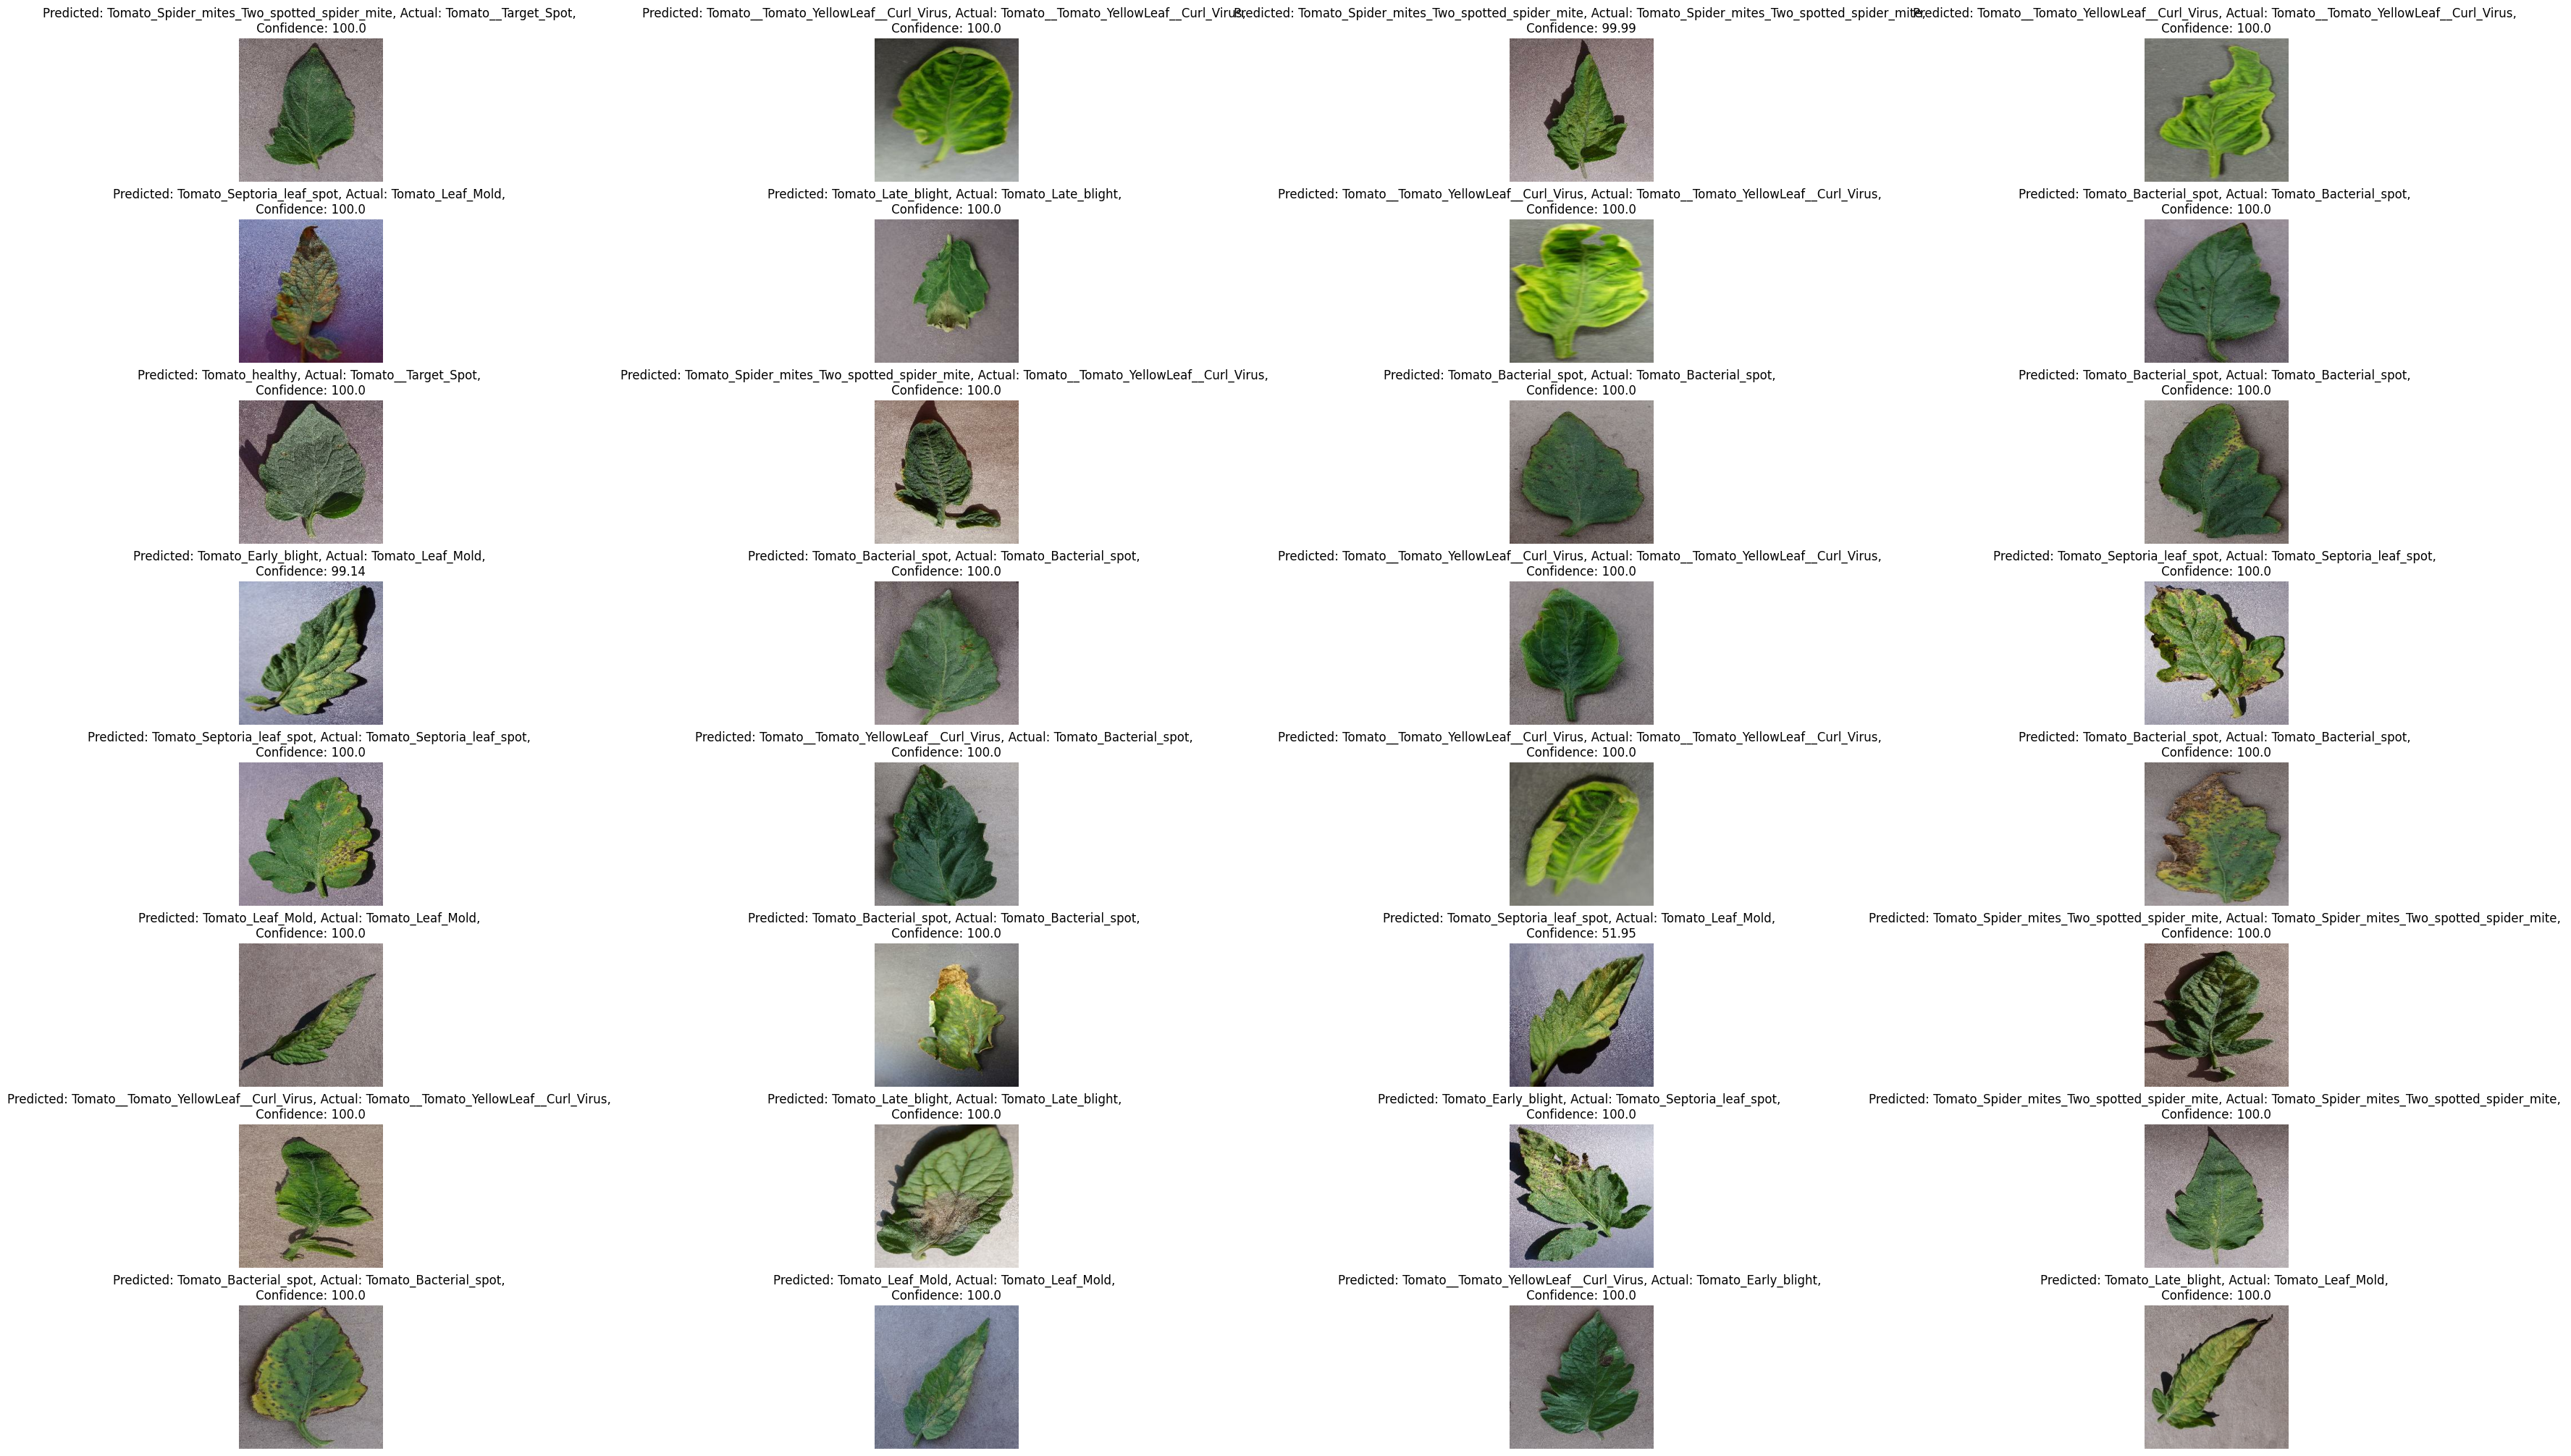

In [44]:
plt.figure(figsize=(35,20),constrained_layout=True)
for images, labels in test_ds.take(1):
    for i in range(len(images)):
        plt.subplot(8,4,i+1)
        plt.imshow((images[i].numpy()*255).astype('uint8'))

        predicted_class,confidence=predicting(model_edited,images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Predicted: {predicted_class}, Actual: {actual_class}, \n Confidence: {confidence} ")
        plt.axis("off")

In [45]:
#we save the model in format "num_accuracy"
model_numbers=[]
for m in os.listdir("models"):
    if not m.startswith("."):
        list_number=re.findall('^[0-9]+',m)
        model_numbers.append(int(list_number[0]))   
print(model_numbers)
model_version= max(model_numbers + [0])+1
model_version
loss,accuracy = model_edited.evaluate(test_ds)
accuracy=round(accuracy,2)
model_edited.save(f"models/{model_version}_{accuracy}.keras")

[5, 9, 6, 3, 7, 4, 8, 1, 2]
51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 0.8014 - loss: 4.5187


In [46]:
def idx_to_class(labels):
    classes_list=[]
    for index_label in labels:  
        classes_list.append(class_names[index_label])
    return classes_list
#testing
for image_batch,labels_batch in test_ds.take(1):
    classes_list=idx_to_class(labels_batch)
    print(classes_list)
    print(labels_batch.numpy())
print(class_names)

['Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato_Bacterial_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Early_blight', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Leaf_Mold', 'Tomato__Target_Spot', 'Tomato_Early_blight', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_Late_blight', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Leaf_Mold', 'Tomato_healthy', 'Tomato_healthy', 'Tomato_Leaf_Mold', 'Tomato_Late_blight', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato_Bacterial_spot', 'Tomato_healthy', 'Tomato_Bacterial_spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Late_blight', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_YellowLeaf__Curl_Vi

2025-08-07 15:52:19.157893: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━

2025-08-07 15:52:25.916651: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<Figure size 1000x800 with 0 Axes>

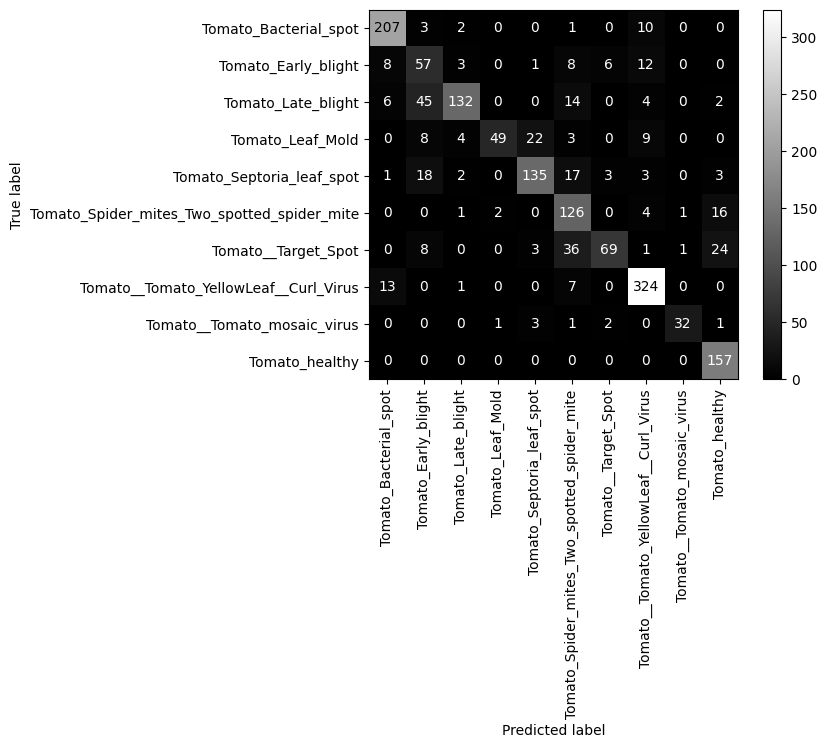

In [47]:
#confusion matrix!
true_classes=[]
predicted_classes=[]
for images, labels in test_ds:
    pred=model_edited.predict(images)
    true_classes.extend(idx_to_class(labels))
    predicted_classes.extend(idx_to_class(np.argmax(pred,1)))
true_classes=np.array(true_classes)
predicted_classes=np.array(predicted_classes)


cm = confusion_matrix(true_classes, predicted_classes,labels=class_names)

plt.figure(figsize=(10, 8))
display=ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=class_names,
                               )
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix')
display.plot(xticks_rotation="vertical",
            cmap="gist_gray")


In [65]:
model_edited.evaluate(test_ds)

51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.7885 - loss: 4.6706


[5.017166614532471, 0.7892156839370728]

LOOK HERE!!!!

we train with a pretrained model to hopefully get better accuracy!

In [48]:
input_shape=layers.Input(shape=(256,256,3))
base_model=tf.keras.applications.ResNet50V2(
    weights='imagenet',
    include_top=False,
    input_tensor=input_shape
)
base_model.trainable=False # Freeze the model

In [49]:
#add new layers 
x = base_model.output  # features from the last conv block
x = layers.GlobalAveragePooling2D()(x)  # flatten feature maps
x = layers.Dense(128, activation='relu')(x)  # optional hidden layer
outputs = layers.Dense(num_classes, activation='softmax')(x)  # final classification

#create full model
model1=models.Model(inputs=input_shape,outputs=outputs)

In [50]:
LRS=tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True
)

optimizer=tf.keras.optimizers.Adam(learning_rate=LRS)
model1.compile(optimizer=optimizer,
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),# the labels are represented as integers corresponding to the class indices. The true labels are integers where each integer represents the class index.
                metrics=['accuracy']) #output is probabilities and not logits so from_logits=False

In [51]:
model1.summary(
)

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer_6[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 64, 64,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 64, 64,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 66, 66,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 64, 64,    │          0 │ conv2_block1_0_c

 Total params: 23,828,362 (90.90 MB)

 Trainable params: 263,562 (1.01 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [52]:
checkpoint_path1='checkpoints2/ckpt/checkpoint.model.keras'
checkpoint_dir1=os.path.dirname(checkpoint_path1)

#create checkpoint callback
cp_callback1= tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_best_only=True,
    monitor="val_loss",
    mode='min',
    verbose=1)
#create early stopping
es_callback1=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=0,
    mode='min',
    restore_best_weights=True
)

#create Learning rate scheduler?
# LRS_callback=tf.keras.callbacks.LearningRateScheduler(

# )

history1=model1.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=batch_size,
    callbacks=[cp_callback1,es_callback1],
    epochs=epochs
)

Epoch 1/12
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 605ms/step - accuracy: 0.6193 - loss: 1.1764
Epoch 1: val_loss improved from inf to 0.52113, saving model to checkpoints/ckpt/checkpoint.model.keras
400/400 ━━━━━━━━━━━━━━━━━━━━ 284s 696ms/step - accuracy: 0.6196 - loss: 1.1755 - val_accuracy: 0.8269 - val_loss: 0.5211
Epoch 2/12
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.8585 - loss: 0.4153
Epoch 2: val_loss improved from 0.52113 to 0.46043, saving model to checkpoints/ckpt/checkpoint.model.keras
400/400 ━━━━━━━━━━━━━━━━━━━━ 290s 725ms/step - accuracy: 0.8585 - loss: 0.4153 - val_accuracy: 0.8431 - val_loss: 0.4604
Epoch 3/12
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step - accuracy: 0.9031 - loss: 0.2926
Epoch 3: val_loss improved from 0.46043 to 0.40599, saving model to checkpoints/ckpt/checkpoint.model.keras
400/400 ━━━━━━━━━━━━━━━━━━━━ 286s 715ms/step - accuracy: 0.9031 - loss: 0.2926 - val_accuracy: 0.8625 - val_loss: 0.4060
Epoch 4/12
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step

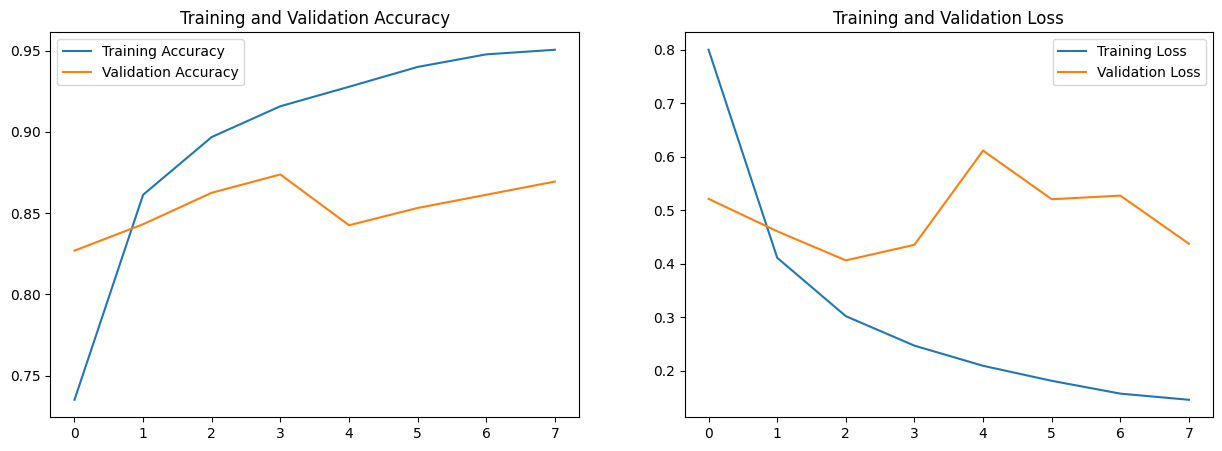

In [53]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(history1.epoch,history1.history['accuracy'],label="Training Accuracy")
plt.plot(history1.epoch,history1.history['val_accuracy'],label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.subplot(1,2,2)
plt.plot(history1.epoch,history1.history['loss'],label="Training Loss")
plt.plot(history1.epoch,history1.history['val_loss'],label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()


<class 'tensorflow.python.framework.ops.EagerTensor'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Tomato_Bacterial_spot
<class 'tensorflow.python.framework.ops.EagerTensor'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Tomato_Bacterial_spot
<class 'tensorflow.python.framework.ops.EagerTensor'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Tomato__Tomato_YellowLeaf__Curl_Virus
<class 'tensorflow.python.framework.ops.EagerTensor'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Tomato__Target_Spot
<class 'tensorflow.python.framework.ops.EagerTensor'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Tomato_Bacterial_spot
<class 'tensorflow.python.framework.ops.EagerTensor'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Tomato_Late_blight
<class 'tensorflow.python.framework.ops.EagerTensor'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Tomato_Bacterial_spot
<class 'tensorflow.python.framework.ops.EagerTensor'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Tomato__Tomato_YellowLeaf__Curl_Virus
<class 'tensorflow.python.framework.ops.EagerTensor'>
1/1 ━━━━━

2025-08-07 16:37:10.711461: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


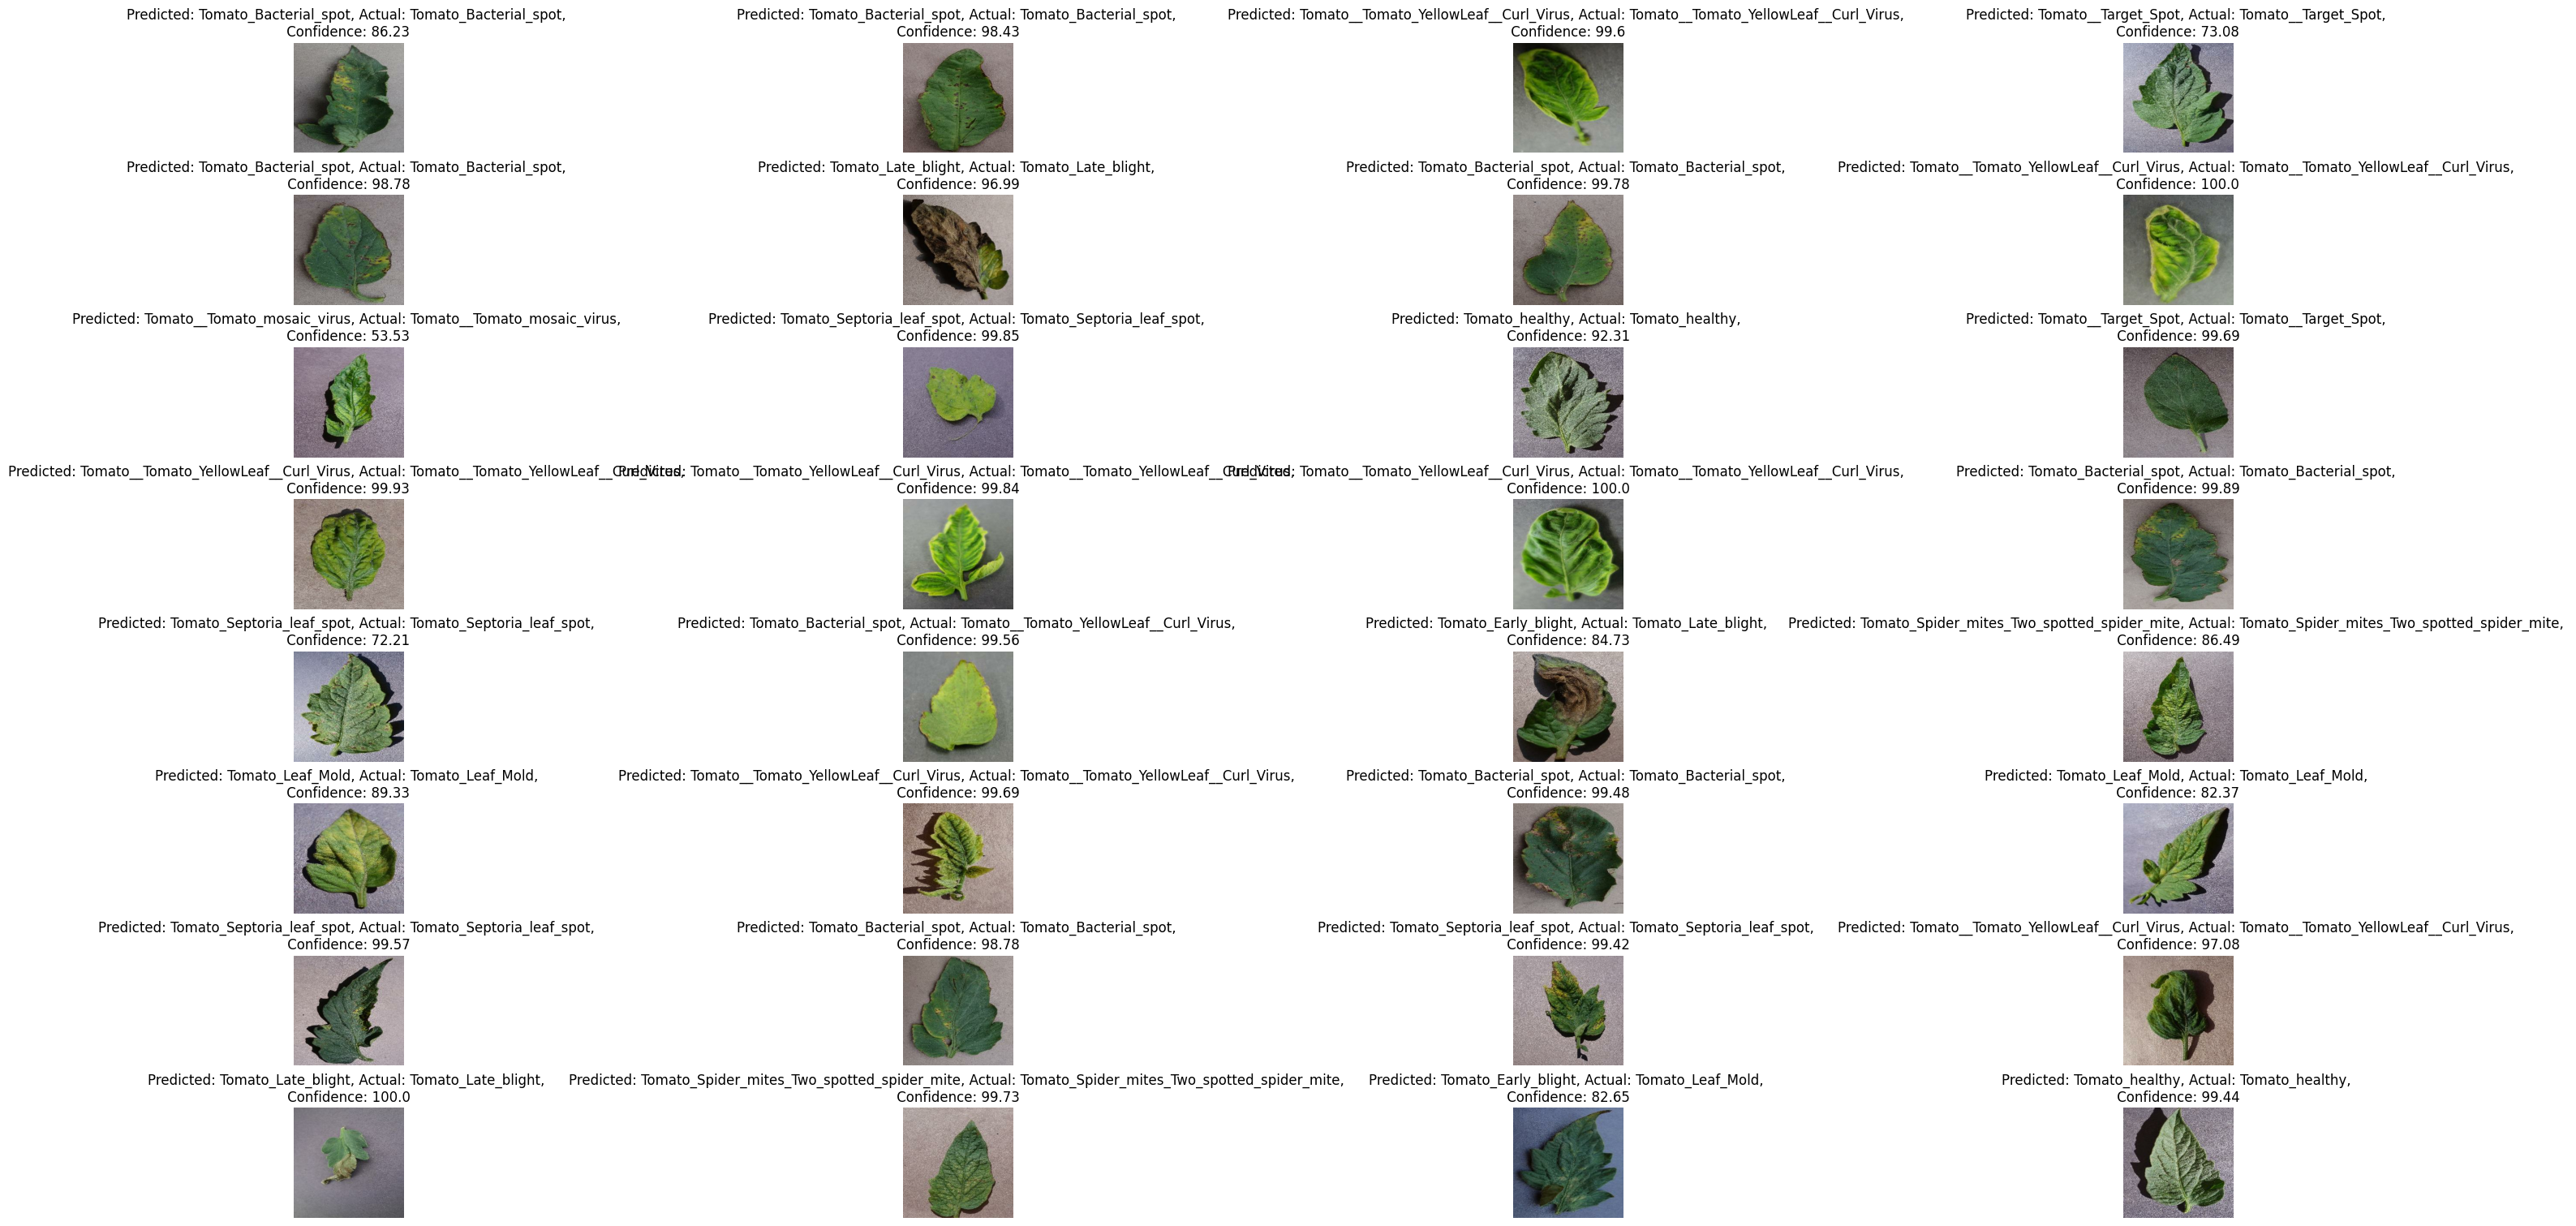

In [54]:
plt.figure(figsize=(30,15),constrained_layout=True)
for images, labels in test_ds.take(1):
    for i in range(len(images)):
        plt.subplot(8,4,i+1)
        plt.imshow((images[i].numpy()*255).astype('uint8'))
        print(type(images[i]))
        predicted_class,confidence=predicting(model1,images[i].numpy())
        print(predicted_class)
        actual_class = class_names[labels[i]]

        plt.title(f"Predicted: {predicted_class}, Actual: {actual_class}, \n Confidence: {confidence} ")
        plt.axis("off")
        plt.autoscale(tight=True)

In [55]:
model1.evaluate(test_ds)

51/51 ━━━━━━━━━━━━━━━━━━━━ 43s 833ms/step - accuracy: 0.8770 - loss: 0.3722


[0.372731477022171, 0.876838207244873]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 867ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 791

2025-08-07 16:38:42.099305: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<Figure size 1000x800 with 0 Axes>

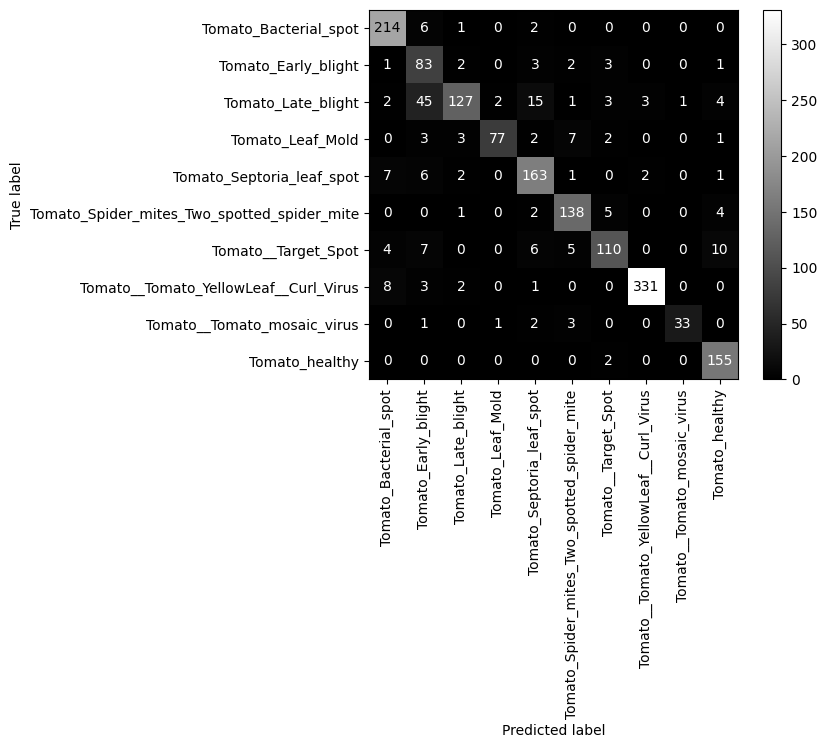

In [56]:
#confusion matrix!
true_classes=[]
predicted_classes=[]
for images, labels in test_ds:
    pred=model1.predict(images)
    true_classes.extend(idx_to_class(labels))
    predicted_classes.extend(idx_to_class(np.argmax(pred,1)))
true_classes=np.array(true_classes)
predicted_classes=np.array(predicted_classes)


cm = confusion_matrix(true_classes, predicted_classes,labels=class_names)

plt.figure(figsize=(10, 8))
display=ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=class_names,
                               )
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix')
display.plot(xticks_rotation="vertical",
            cmap="gist_gray")


In [57]:

str="10_0.79"
list=re.findall('^[0-9]+',str)
int(list[0])


10

In [ ]:
#we save the model in format "num_accuracy"
model_numbers=[]
for m in os.listdir("pt_models"):
    if not m.startswith("."):
        list_number=re.findall('^[0-9]+',m)
        model_numbers.append(int(list_number[0]))   
print(model_numbers)
model_version= max(model_numbers + [0])+1
model_version
loss,accuracy = model1.evaluate(test_ds)
accuracy=round(accuracy,2)
model1.save(f"pt_models/{model_version}_{accuracy}.keras")

[2, 3, 4, 1, 6, 5]
51/51 ━━━━━━━━━━━━━━━━━━━━ 40s 789ms/step - accuracy: 0.8737 - loss: 0.3690


In [59]:
model1.evaluate(test_ds)

51/51 ━━━━━━━━━━━━━━━━━━━━ 41s 801ms/step - accuracy: 0.8700 - loss: 0.3874


[0.3727315366268158, 0.876838207244873]

In [60]:
model1.evaluate(test_ds)

51/51 ━━━━━━━━━━━━━━━━━━━━ 39s 768ms/step - accuracy: 0.8705 - loss: 0.4020


[0.37273144721984863, 0.876838207244873]